# CV Challenge: Task 1
Welcome to the first notebook of the CV Challenge project, where we aim to solve the problem of object detection and classification. This notebook specifically focuses on preparing the data into the TFRecordDataset format, which is a highly efficient and scalable way to handle large datasets in TensorFlow.

This notebook is part of a two-part series:

- **Task1_cv_challenge_forstehaeusler.ipynb**

- Task2_cv_challenge_forstehaeusler.ipynb

In this notebook, we will walk through the process of preparing the dataset for our computer vision challenge. The tasks include data loading, preprocessing, and converting the data into the TFRecordDataset format. This format is particularly useful for optimizing data reading and training pipeline performance in TensorFlow.

The author of this notebook is Christoph Forstenhäusler. Let's dive into the exciting world of computer vision and tackle our first task!


## Dataset
For this challenge, we utilized the NEU Surface Defect Database, which consists of six types of typical surface defects found in hot-rolled steel strips. These defects include rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In), and scratches (Sc). The dataset comprises 1,800 grayscale images, with 300 samples for each defect type. These samples are split into 240 images for training and 60 images for testing.

You can download the dataset from Kaggle using the following link https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database

In [1]:
path_to_dataset = "NEU-DET"                         # Path to the directory containing the NEU Surface Defect Database

## Task 1 - Preparing the Data in the Requested Format

In this task, our goal is to organize the data into the requested format by creating two folders: `train` and `test`, each containing a certain number of **TFRecord files**. To accomplish this, we need to define a specific path where these two folders will be stored

In [2]:
import os

save_tfRecord_folder = "TFRecordDataset"            # Specify the directory path where the TFRecord will be stored

save_tfRecord_sub_folder = [os.path.join(save_tfRecord_folder, "train"), os.path.join(save_tfRecord_folder, "test")]       

if not os.path.exists(save_tfRecord_folder):
    os.makedirs(save_tfRecord_sub_folder[0])
    os.makedirs(save_tfRecord_sub_folder[1])
    print("Successfully created new directory.")
else:
    print("Directory path already exist. Make sure the train and test folders exist and are empty!")

Successfully created new directory.


Let's explore the different types of surface defects, as we will need to loop through them in the next section.


In [3]:
categories = os.listdir(os.path.join(path_to_dataset, "train", "images"))
print(f"Explore all Surface Defect Categories:\n")
for num, label in enumerate(categories):
    print(f"Surface Defect {num}: {label}")

Explore all Surface Defect Categories:

Surface Defect 0: crazing
Surface Defect 1: inclusion
Surface Defect 2: patches
Surface Defect 3: pitted_surface
Surface Defect 4: rolled-in_scale
Surface Defect 5: scratches


In this section, we utilize functions from `utils_task1` to extract information from annotations and serialize it into TFRecord files. We iterate through the dataset folders, loading each image and its corresponding annotations. If an annotation file is missing, a warning is issued, and the image is skipped. Extracted information such as image dimensions, class labels, and bounding box coordinates is then serialized and saved in TFRecord format. This approach streamlines the preparation of data for training machine learning models.

In [4]:
from src.utils_task1 import serialize_info, extract_info_from_xml_file
import matplotlib.pyplot as plt

for i, sub_folder_dataset in enumerate(os.listdir(path_to_dataset)):
    base_path_folder = save_tfRecord_sub_folder[i]
    print(f"Info:\t\tAll Images with Annotations from the sorce folder '{sub_folder_dataset}' are stored under '{base_path_folder}'")
    for surface_defect in categories:
        img_names = os.listdir(os.path.join(path_to_dataset, sub_folder_dataset, "images", surface_defect))
        for filename in img_names:
            image = plt.imread(os.path.join(path_to_dataset, sub_folder_dataset, "images", surface_defect, filename))
            anno_name = filename.split(".")[0]
            anno_xml_path = os.path.join(path_to_dataset, sub_folder_dataset, "annotations", f'{anno_name}.xml')
            base_path_folder = save_tfRecord_sub_folder[i]
            
            if os.path.exists(anno_xml_path):
                #extract the info from the annotation
                width, height, source_id, format, xmin, xmax, ymin, ymax, class_text, class_label, class_single, difficult, truncated, view = extract_info_from_xml_file(filename=filename, anno_xml=anno_xml_path)
                recored_bytes = serialize_info(base_path_folder, width, height, filename, source_id, image, format, xmin, xmax, ymin, ymax, class_text, class_label, class_single, difficult, truncated, view)
            else:
                print(f"Warning: \tNo annotation file was found for the Image {filename} ---- This Image will not be included into the TFRecordDataset!")


Info:		All Images with Annotations from the sorce folder 'train' are stored under 'TFRecordDataset\train'
Info:		All Images with Annotations from the sorce folder 'validation' are stored under 'TFRecordDataset\test'


## Validate TFRecord Dataset Decoding

This section is dedicated to verifying the decoding process of TFRecord datasets. The primary objective is to ensure that the TFRecord dataframes can be decoded correctly, guaranteeing that the information stored within them can be effectively extracted and utilized.

Decoded Image Information:

  Filename: 	crazing_17.jpg
  Source ID: 	NEU-DET
  Format: 	jpg


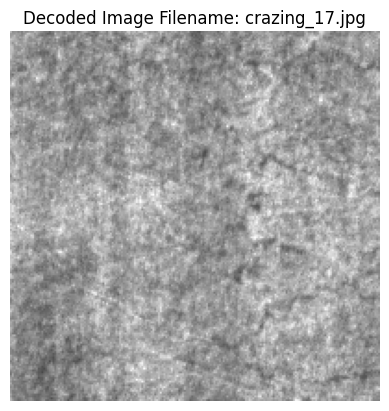

 Bounding Box Information:
  xmin: [111. 124.], xmax: [188. 195.]
  ymin: [66.  6.], ymax: [174. 102.]

 Class Text: 	[b'crazing' b'crazing']
 Class Label: 	[0 1]
 Single Class: 	0
 Difficult: 	[0 0]
 Truncated: 	[0 0]
 View: 		[b'Unspecified' b'Unspecified']



In [6]:
from src.utils_task1 import decode_info
import tensorflow as tf
import random

#Random Check on Train TFRecords
train_files = os.listdir(save_tfRecord_sub_folder[0])
random_train_file = random.choice(train_files)
check_decode = os.path.join(save_tfRecord_sub_folder[0], random_train_file)

for batch in tf.data.TFRecordDataset(check_decode).map(decode_info):
    # Decodierte Bildinformationen
    filename = batch['image/filename'].numpy().decode('utf-8')
    source_id = batch['image/source_id'].numpy().decode('utf-8')
    image_format = batch['image/format'].numpy().decode('utf-8')
    print(f"Decoded Image Information:\n\n  Filename: \t{filename}\n  Source ID: \t{source_id}\n  Format: \t{image_format}")

    # Visualisierung des Bildes
    image_raw = batch['image/encodedrawdata']
    decoded_image = tf.io.parse_tensor(image_raw, out_type=tf.uint8).numpy()
    plt.imshow(decoded_image)
    plt.title(f"Decoded Image Filename: {filename}")
    plt.axis('off')
    plt.show()

    # Bounding Box Informationen
    xmin = tf.sparse.to_dense(batch['image/object/bbox/xmin']).numpy()
    xmax = tf.sparse.to_dense(batch['image/object/bbox/xmax']).numpy()
    ymin = tf.sparse.to_dense(batch['image/object/bbox/ymin']).numpy()
    ymax = tf.sparse.to_dense(batch['image/object/bbox/ymax']).numpy()
    print(f" Bounding Box Information:\n  xmin: {xmin}, xmax: {xmax}\n  ymin: {ymin}, ymax: {ymax}\n")

    # Klassenbezeichnungen
    class_text = tf.strings.as_string(tf.sparse.to_dense(batch['image/object/class/text'])).numpy()
    print(f" Class Text: \t{class_text}")

    # Klassenlabel
    class_label = tf.sparse.to_dense(batch['image/object/class/label']).numpy()
    print(f" Class Label: \t{class_label}")

    # Einzelnes Klassenattribut
    class_single = batch['image/object/class/single'].numpy()
    print(f" Single Class: \t{class_single}")

    # Schwierigkeitsgrad
    difficult = tf.sparse.to_dense(batch['image/object/difficult']).numpy()
    print(f" Difficult: \t{difficult}")

    # Truncated
    truncated = tf.sparse.to_dense(batch['image/object/truncated']).numpy()
    print(f" Truncated: \t{truncated}")

    # Ansicht
    view = tf.strings.as_string(tf.sparse.to_dense(batch['image/object/view'])).numpy()
    print(f" View: \t\t{view}\n")


### Proceed to the second notebook, as this concludes the data preparation phase, and we will now continue with image classification in the Task2_cv_challenge Notebook